### Author: Wei Zhang.
# In this notebook we will show how to use the NonStationaryConvolve3D operator in pylops to perform 3D image-domain least-squares migration through PSFs
# More details for seismic acquisition, please refer to the 3D numerical exmaple in this paper: Wei Zhang,  A tutorial of image-domain least-squares reverse time migration through point spread functions, Geophysics, 2023,https://library.seg.org/doi/10.1190/geo2022-0629.1

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

In [2]:
# from ID_cuda import NonStationaryConvolve3D
from pylops.signalprocessing.nonstatconvolve3d import NonStationaryConvolve3D

/home/ravasim/miniconda3_v23/envs/pylops_cupy_3090_working/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *
from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

# Model and data load for a part of 3D overthrust

In [4]:
mig_file ="../data/ilsmig/mig-351-121-151.bin"
psf_file ="../data/ilsmig/psf-351-121-151.bin"
vel_file ="../data/ilsmig/vp.bin"
ref_file ="../data/ilsmig/ref.bin"
nx=351; 		ny=121; 		nz=151;
wx=25;		    wy=25;		    wz=25;
dx=10;          dy=10;          dz=10;
shape_list=(nx,ny,nz);
psf_list=(wx,wy,wz);

In [5]:
mig_arr = np.fromfile(mig_file, np.float32);
psf_arr = np.fromfile(psf_file, np.float32);
ref_arr = np.fromfile(ref_file, np.float32);
vel_arr = np.fromfile(vel_file, np.float32);
mig_arr = mig_arr.reshape(shape_list)
psf_arr = psf_arr.reshape(shape_list)
ref_arr = ref_arr.reshape(shape_list)
vel_arr = vel_arr.reshape(shape_list)

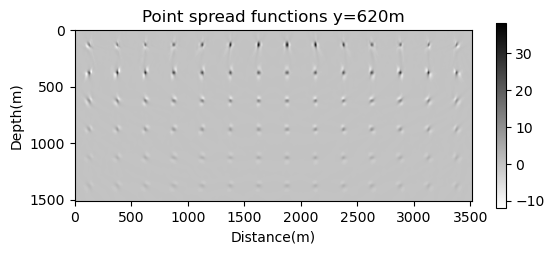

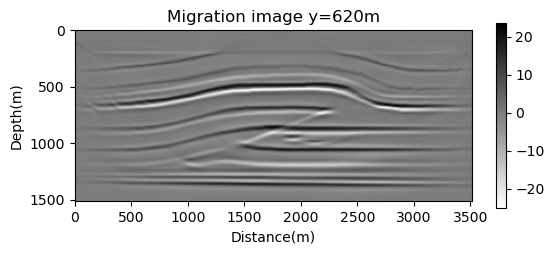

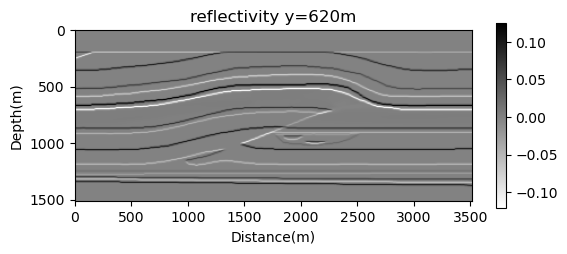

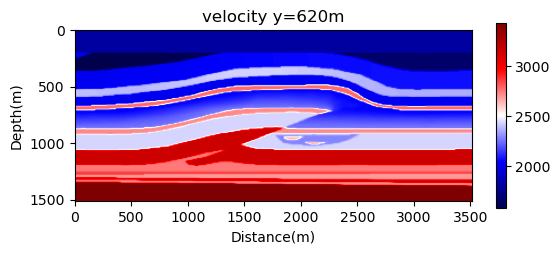

In [6]:
plot_y  = ny//2//wy*wy+wy//2

plt.figure(); im = plt.imshow(psf_arr[:,plot_y,:].reshape(nx,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("Point spread functions " +  "y=" + str(plot_y*dy) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure(); im = plt.imshow(mig_arr[:,plot_y,:].reshape(nx,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("Migration image " +  "y=" + str(plot_y*dy) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure(); im = plt.imshow(ref_arr[:,plot_y,:].reshape(nx,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("reflectivity " +  "y=" + str(plot_y*dy) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure(); im = plt.imshow(vel_arr[:,plot_y,:].reshape(nx,nz).T, cmap='seismic',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("velocity " +  "y=" + str(plot_y*dy) + "m"); plt.colorbar(im, shrink=0.5)

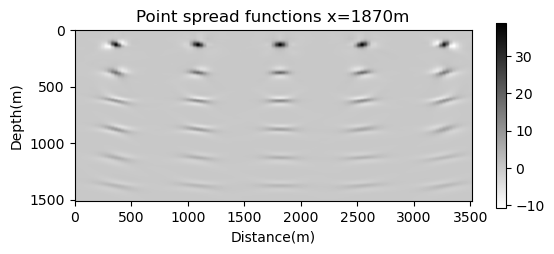

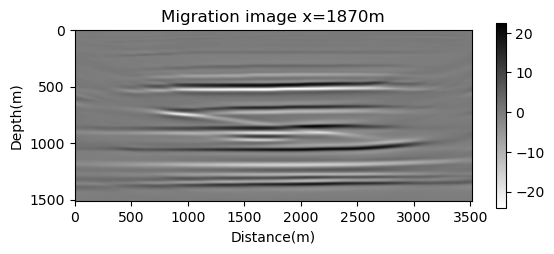

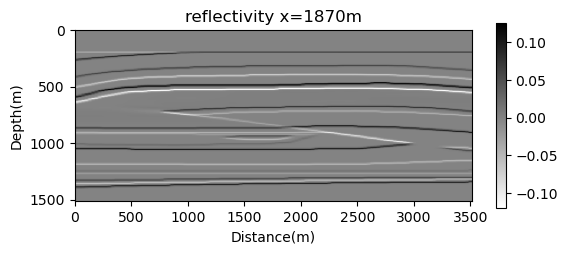

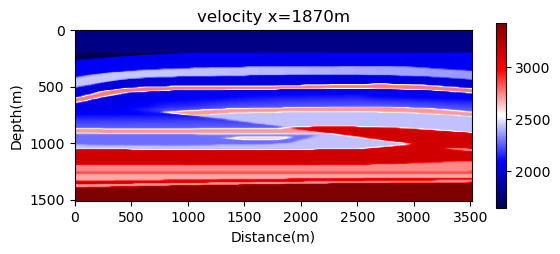

In [7]:
plot_x  = nx//2//wx*wx+wx//2
plt.figure();im=plt.imshow(psf_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("Point spread functions " +  "x=" + str(plot_x*dx) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure();im=plt.imshow(mig_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("Migration image " +  "x=" + str(plot_x*dx) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure();im=plt.imshow(ref_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("reflectivity " +  "x=" + str(plot_x*dx) + "m"); plt.colorbar(im, shrink=0.5)

plt.figure();im=plt.imshow(vel_arr[plot_x,:,:].reshape(ny,nz).T, cmap='seismic',extent = (0,nx*dx,nz*dz,0));plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');plt.title("velocity " +  "x=" + str(plot_x*dx) + "m"); plt.colorbar(im, shrink=0.5)


# create the gids of PSF and reshape PSF_arr arr to psfs

In [8]:
#if multiple_psf_bool==0:
# Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')
psfx = np.arange(wx//2, nx, wx)
psfy = np.arange(wy//2, ny, wy)
psfz = np.arange(wz//2, nz, wz)
    
psfs=np.zeros( (len(psfx), len(psfy), len(psfz), wx, wy, wz), dtype=np.float32)

for ipx, px in enumerate(psfx):    
        for ipy, py in enumerate(psfy):
            for ipz, pz in enumerate(psfz):
                
                begx=int( px - wx//2     );
                endx=int( px + wx//2 + 1 );
                
                begy=int( py - wy//2     );
                endy=int( py + wy//2 + 1 );
                
                begz=int( pz - wz//2     );
                endz=int( pz + wz//2 + 1 );
                if endx<=nx and endy<=ny and endz<=nz:
                    psfs[ipx, ipy, ipz, :, :, :] = psf_arr[begx : endx, begy : endy, begz : endz]
                else:
                    psfs[ipx, ipy, ipz, :, :, :] = 0.0;

In [9]:
len(psfx), len(psfy), len(psfz), ny, nx, nz

(14, 5, 6, 121, 351, 151)

# Compare computational times of different engines ["numpy", "numba", "cuda"]

In [10]:
Cop_cuda = NonStationaryConvolve3D(dims=(nx, ny, nz), hs=cp.asarray(psfs).astype(np.float32), ihx=psfx, ihy=psfy, ihz=psfz, engine="cuda", num_threads_per_blocks=(8, 8, 8), dtype=np.float32 )

Cop_numba = NonStationaryConvolve3D(dims=(nx, ny, nz), hs=psfs.astype(np.float32), ihx=psfx, ihy=psfy, ihz=psfz, engine="numba", num_threads_per_blocks=(8, 8, 8), dtype=np.float32 )

Cop_numpy = NonStationaryConvolve3D(dims=(nx, ny, nz), hs=psfs.astype(np.float32), ihx=psfx, ihy=psfy, ihz=psfz, engine="numpy", num_threads_per_blocks=(8, 8, 8), dtype=np.float32 )

In [11]:
# Forward
x = np.zeros((nx, ny, nz))
x[:, :, 101] = 1.
x[:, :, 121] = -1.
xcp = cp.asarray(x)

Cop_numba * x #dry-run
Cop_cuda * xcp #dry-run
#%timeit -n1 -r1 Copnp * x
%timeit -n1 -r1 Cop_numba * x
%timeit -n1 -r1 Cop_cuda * xcp

30.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
start_time = time.time();
mig_sys1  = Cop_cuda._matvec(cp.asarray(ref_arr) ).reshape( shape_list);
end_time = time.time();
# Compute the total execution time
execution_time = end_time - start_time
print("Execution time cuda: ", execution_time, " seconds")

Execution time cuda:  42.06616735458374  seconds


In [13]:
start_time = time.time();
mig_sys2  = Cop_cuda._matvec(cp.asarray(ref_arr) ).reshape( shape_list);
end_time = time.time();
# Compute the total execution time
execution_time = end_time - start_time
print("Execution time cuda: ", execution_time, " seconds")

Execution time cuda:  42.05458974838257  seconds


In [14]:
start_time = time.time();
mig_sys3  = Cop_cuda * cp.asarray(ref_arr);
end_time = time.time();
# Compute the total execution time
execution_time = end_time - start_time
print("Execution time cuda: ", execution_time, " seconds")

Execution time cuda:  41.83208155632019  seconds


In [16]:
start_time = time.time();
mig_sys5  = Cop_numba * ref_arr
end_time = time.time();
## Compute the total execution time
execution_time = end_time - start_time
print("Execution time numba: ", execution_time, " seconds")

Execution time numba:  34.233296632766724  seconds


In [17]:
# res1 = cp.asnumpy( mig_sys1 - mig_sys3 )
res2 = cp.asnumpy( cp.asnumpy(mig_sys1) - mig_sys5 )

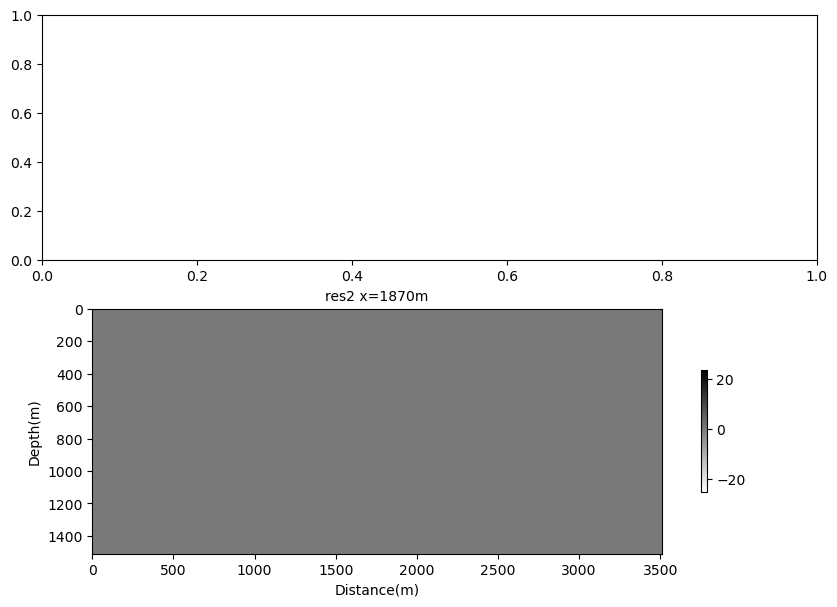

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
# im=axs[0].imshow(res1[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[0].set_title("res1" +  "x=" + str(plot_x*dx) + "m", fontsize=10);fig.colorbar(im, ax=axs[0], shrink=0.5)


im=axs[1].imshow(res2[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[1].set_title("res2 " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[1], shrink=0.5)

# dot test

In [19]:
# dot test dot test
start_time = time.time();
d1      = cp.random.rand( nx,ny,nz ).astype(np.float32) ;
m1      = cp.random.rand( nx,ny,nz ).astype(np.float32) ;
dot1    = cp.sum( Cop_cuda._matvec( m1 ).reshape( shape_list)   * d1 ) ;
dot2    = cp.sum( Cop_cuda._rmatvec( d1 ).reshape( shape_list)   * m1 ) ;

end_time = time.time();
## Compute the total execution time
execution_time = end_time - start_time
print("Execution time numba: ", execution_time, " seconds")

Execution time numba:  44.38832759857178  seconds


In [20]:
file1="dot1 is {}, dot2 is {} \n".format( dot1, dot2 );
print(file1);

dot1 is 91892312.0, dot2 is 91892312.0 



# The residual between PSF*ref_arr and mig_arr

In [23]:
mig_sys  = Cop_cuda.matvec(cp.asarray(ref_arr.ravel())).reshape( shape_list);
mig_res  = cp.asarray(mig_arr) - mig_sys;
mig_sys  = cp.asnumpy(mig_sys)
mig_res  = cp.asnumpy(mig_res)

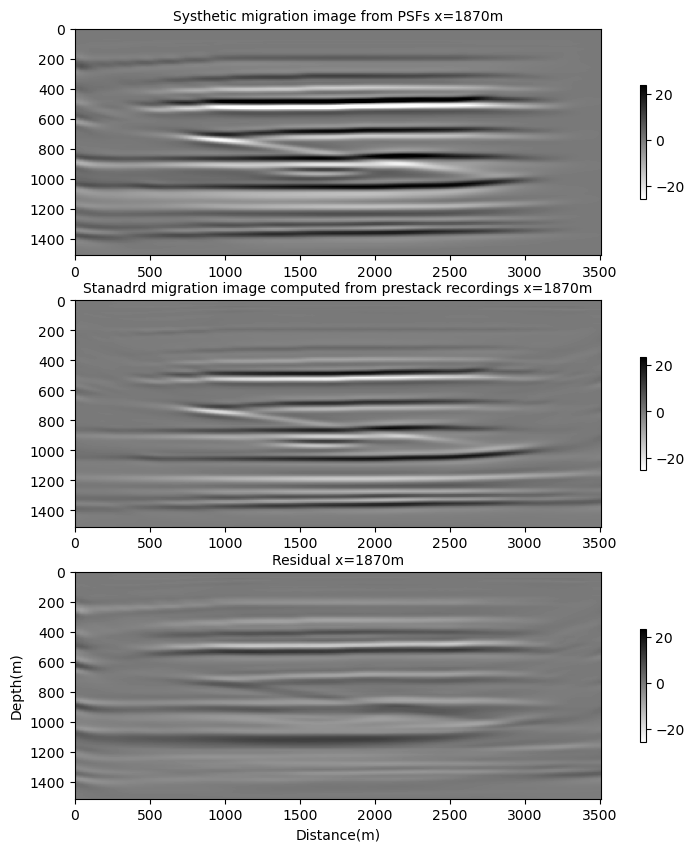

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
im=axs[0].imshow(mig_sys[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[0].set_title("Systhetic migration image from PSFs " +  "x=" + str(plot_x*dx) + "m", fontsize=10);fig.colorbar(im, ax=axs[0], shrink=0.5)

im=axs[1].imshow(mig_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[1].set_title("Stanadrd migration image computed from prestack recordings " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[1], shrink=0.5)

im=axs[2].imshow(mig_res[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[2].set_title("Residual " +  "x=" + str(plot_x*dx) + "m", fontsize=10);   fig.colorbar(im, ax=axs[2], shrink=0.5)

# Image-domain LSM using  standard GD

In [25]:
niter   = 50
ref_inv = cp.zeros( shape_list )
res_arr = np.zeros( niter )
for iter_ in range(0, niter):
    start_time = time.time();

    mig_sys        = Cop_cuda *ref_inv
    mig_res        = mig_sys - cp.asarray(mig_arr)
    res_arr[iter_] = cp.asnumpy( cp.sum(mig_res*mig_res) );
    mig_grad       = Cop_cuda.H * mig_res
    f_grad         = Cop_cuda * mig_grad
    step_length    = cp.sum( f_grad * mig_res) / cp.sum( f_grad*f_grad )
    ref_inv[:]     = ref_inv[:] - 1.0*step_length*mig_grad[:]
    end_time       = time.time();
    
    ## Compute the total execution time
    execution_time = end_time - start_time
    print( "iter={},L2={},step_length={}".format(iter_, res_arr[iter_], step_length) )
    print( "Execution time numba:{} seconds\n".format(execution_time) )

iter=0,L2=63858776.0,step_length=3.1969700557965552e-06
Execution time numba:124.8284957408905 seconds

iter=1,L2=23392842.0,step_length=3.1161193874140736e-06
Execution time numba:82.06395292282104 seconds

iter=2,L2=14923450.0,step_length=3.086872993662837e-06
Execution time numba:83.35340428352356 seconds

iter=3,L2=11159238.0,step_length=3.0241421882237773e-06
Execution time numba:81.7562644481659 seconds

iter=4,L2=9010924.0,step_length=2.999538537551416e-06
Execution time numba:81.57395815849304 seconds

iter=5,L2=7619114.0,step_length=2.9314219318621326e-06
Execution time numba:82.73670554161072 seconds

iter=6,L2=6644165.0,step_length=2.8850199669250287e-06
Execution time numba:81.77731585502625 seconds

iter=7,L2=5925289.0,step_length=2.7917460556636797e-06
Execution time numba:81.81529688835144 seconds

iter=8,L2=5375131.5,step_length=2.728583694988629e-06
Execution time numba:81.53077030181885 seconds

iter=9,L2=4941268.0,step_length=2.6473380785319023e-06
Execution time num

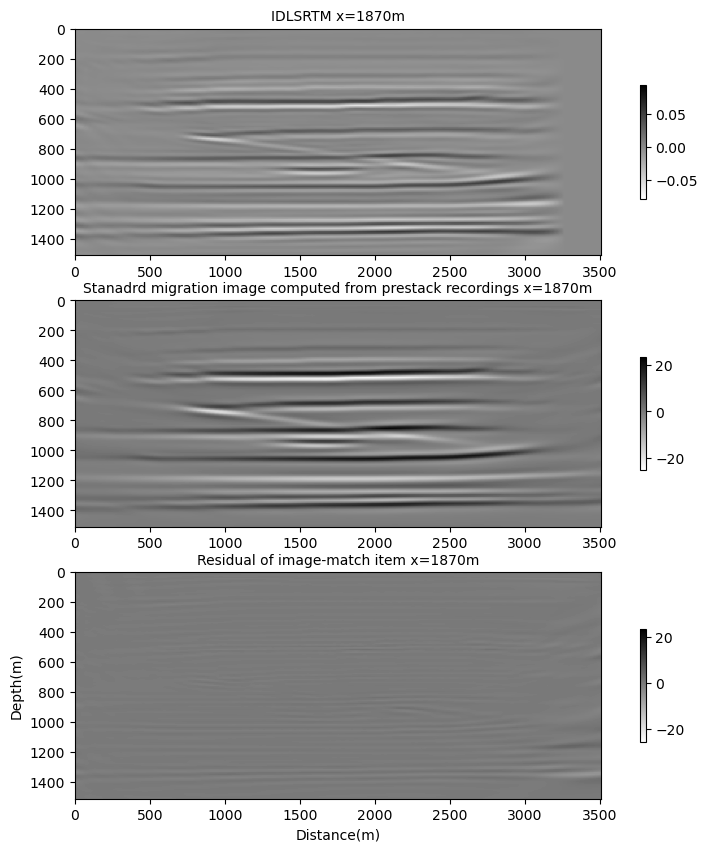

In [26]:
ref_inv  = cp.asnumpy(ref_inv);
mig_res  = cp.asnumpy(mig_res);

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

im=axs[0].imshow(ref_inv[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=ref_inv.min()*1, vmax=ref_inv.max()*1 );plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[0].set_title("IDLSRTM " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[0], shrink=0.5)


im=axs[1].imshow(mig_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[1].set_title("Stanadrd migration image computed from prestack recordings " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[1], shrink=0.5)


im=axs[2].imshow(mig_res[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[2].set_title("Residual of image-match item " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[2], shrink=0.5)

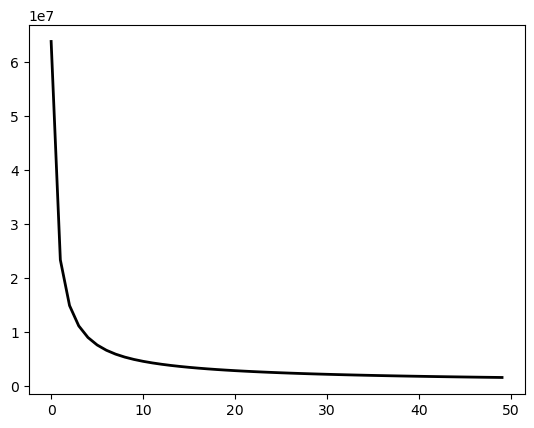

In [27]:
plt.figure()
plt.plot(res_arr, 'k', lw=2);

# Image-domain LSM using FISTA

In [32]:
reflinv, _, resnorm = fista(Cop_cuda, cp.asarray(mig_arr).ravel(), eps=4e1, niter=20, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = cp.asnumpy(reflinv).reshape(  shape_list )

mig_res  = mig_arr - cp.asnumpy(   Cop_cuda.matvec(cp.asarray(reflinv.ravel()))).reshape(mig_arr.shape)

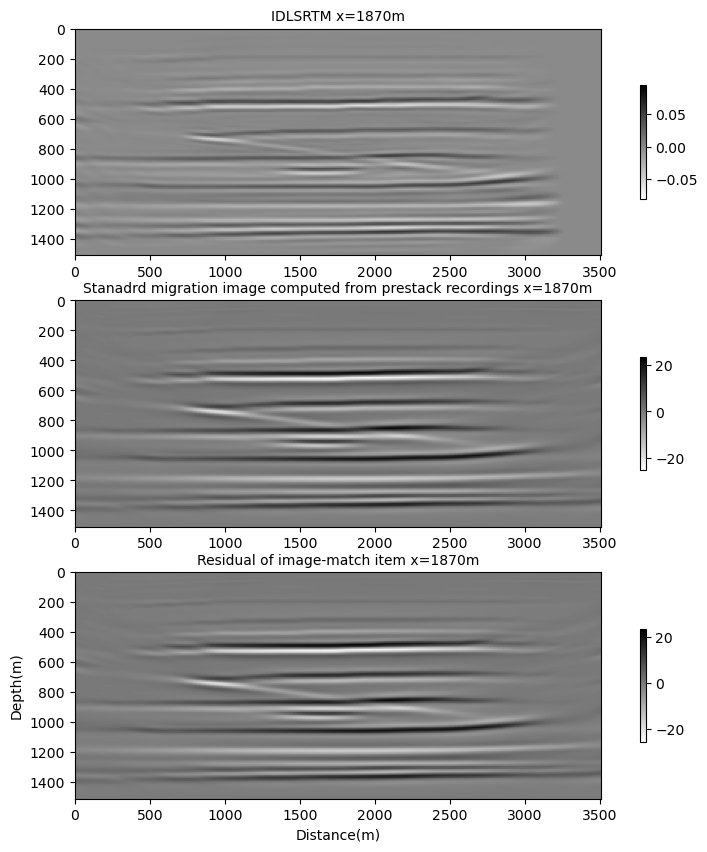

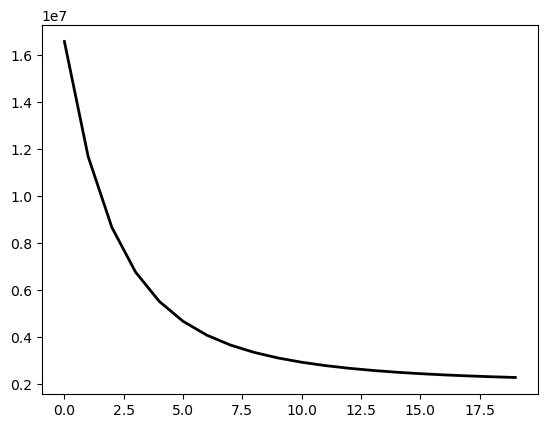

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

im=axs[0].imshow(reflinv[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=reflinv.min(), vmax=reflinv.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[0].set_title("IDLSRTM " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[0], shrink=0.5)

im=axs[1].imshow(mig_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[1].set_title("Stanadrd migration image computed from prestack recordings " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[1], shrink=0.5)

im=axs[2].imshow(mig_arr[plot_x,:,:].reshape(ny,nz).T, cmap='gray_r',extent = (0,nx*dx,nz*dz,0), vmin=mig_arr.min(), vmax=mig_arr.max() );
plt.xlabel('Distance(m)');plt.ylabel('Depth(m)');axs[2].set_title("Residual of image-match item " +  "x=" + str(plot_x*dx) + "m", fontsize=10); fig.colorbar(im, ax=axs[2], shrink=0.5)

plt.figure()
plt.plot(resnorm, 'k', lw=2);